In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [188]:
#Parameters


#MACD parameters
n = 9
m = 19
t = 6

#RSI parameters
period = 14

In [189]:
dataimport = pd.read_csv('/Users/hitengoel/Machine Learning/data analysis(technical indiactors)/data-analysis-with-technical-indicators/Pair Trading final/data/Indexes/SHSZ300 (CSI 300).csv')


dataimport['Date'] = pd.to_datetime(dataimport['Date'])
dataimport.set_index('Date', inplace=True)
data = dataimport.copy()

data.reset_index(inplace=True)
data['Date'] = data['Date'].astype(str)
stock_names = data.columns[1:]

datacopy = data.copy()

data

,Date,600519 CH Equity,600036 CH Equity,000858 CH Equity,600900 CH Equity,600030 CH Equity,600276 CH Equity,600887 CH Equity,600309 CH Equity,000651 CH Equity,...,000069 CH Equity,600754 CH Equity,000617 CH Equity,600803 CH Equity,600884 CH Equity,000708 CH Equity,000877 CH Equity,600606 CH Equity,000800 CH Equity,001289 CH Equity
0,2011-01-03,138.182,12.566,34.63,7.57,11.870,7.094,6.377,12.301,9.059,...,5.192,23.23,13.957,12.365,8.610,9.035,17.539,5.184,16.05,15.33
1,2011-01-04,139.369,12.772,34.62,7.61,12.209,6.845,6.525,12.385,9.079,...,5.491,23.65,14.421,12.235,8.676,9.176,18.578,5.370,16.50,15.54
2,2011-01-05,136.048,12.723,33.68,7.60,11.992,6.626,6.485,12.615,8.989,...,5.436,23.50,14.214,12.235,8.700,9.088,18.822,5.313,16.72,15.75
3,2011-01-06,135.417,12.654,33.45,7.60,11.926,6.493,6.147,13.071,9.019,...,5.466,22.89,14.607,12.356,8.462,8.953,18.783,5.342,16.61,15.47
4,2011-01-07,135.026,12.998,33.30,7.64,12.040,6.670,6.120,12.853,8.844,...,5.513,23.21,14.143,12.356,8.486,9.024,18.350,5.399,16.82,15.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125,2022-12-26,1742.060,35.950,178.60,20.37,19.670,37.560,30.570,90.280,32.350,...,5.440,58.15,5.800,16.350,17.510,17.200,8.670,3.000,7.82,17.43
3126,2022-12-27,1733.000,36.670,181.05,20.54,20.140,37.070,31.160,91.840,32.630,...,5.450,58.60,5.730,16.030,17.880,17.180,8.700,3.050,7.92,17.78
3127,2022-12-28,1733.000,37.330,180.18,20.67,20.050,37.400,30.930,92.860,32.570,...,5.480,58.10,5.650,16.180,17.790,17.310,8.660,3.070,7.74,18.80
3128,2022-12-29,1719.000,37.230,178.75,20.80,19.780,38.130,30.870,92.910,32.160,...,5.280,58.23,5.610,16.140,18.620,17.110,8.360,2.960,7.71,18.21


In [190]:
def MACD(price_data, short_window, long_window, signal_window, column_name):
    data = price_data
   
    data.loc[:,'EMAn'] = data[column_name].ewm(span=short_window, adjust=False).mean()
    data.loc[:,'EMAm'] = data[column_name].ewm(span=long_window, adjust=False).mean()

    for i in range(short_window):
        data.loc[i,'EMAn'] = None
    for i in range(long_window):
        data.loc[i,'EMAm'] = None
    
    data['MACD'] = data['EMAn'] - data['EMAm']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    trade_sig=np.zeros([len(data),1],dtype=float)

    for i in range(long_window+1,len(data)):
        if data.loc[i,'MACD'] > data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] < data.loc[i-1,'Signal Line']:
            trade_sig[i] = 1
        if data.loc[i,'MACD'] < data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] > data.loc[i-1,'Signal Line']:
            trade_sig[i] = -1
        
    trade_sig=trade_sig.reshape(len(trade_sig),1)

    data_numpy=data['Date'].to_numpy()
    data_numpy=data_numpy.reshape(len(data_numpy),1)
    data_numpy=np.column_stack((data_numpy,data[column_name].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAn'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAm'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['MACD'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['Signal Line'].to_numpy()))

    final=np.column_stack((data_numpy,trade_sig))
    final_df=pd.DataFrame(final,columns=['Date','Close','EMAn','EMAm','MACD','Signal Line','Trade Signal'],index=data.index)

    final_df.drop(["EMAn","EMAm","MACD","Signal Line"],axis=1,inplace=True)
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    final_df['Close'] = final_df['Close'].astype(float) 
    final_df['Trade Signal'] = final_df['Trade Signal'].astype(int)

    return final_df


master_macd = pd.DataFrame()

for name in stock_names:
    temp = MACD(data, n, m, t, name)
    temp = temp[['Date','Trade Signal']]
    temp.columns = ['Date',name]
    temp.set_index('Date', inplace=True)
    master_macd = pd.concat([master_macd, temp], axis=1)

In [191]:
master_macd.insert(0, 'Date', master_macd.index)
master_macd.reset_index(drop=True, inplace=True)
master_macd = master_macd[period:]
master_macd = master_macd.reset_index(drop=True)
#master_macd = master_macd[232:725]
master_macd

,Date,600519 CH Equity,600036 CH Equity,000858 CH Equity,600900 CH Equity,600030 CH Equity,600276 CH Equity,600887 CH Equity,600309 CH Equity,000651 CH Equity,...,000069 CH Equity,600754 CH Equity,000617 CH Equity,600803 CH Equity,600884 CH Equity,000708 CH Equity,000877 CH Equity,600606 CH Equity,000800 CH Equity,001289 CH Equity
0,2011-01-21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,2022-12-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3112,2022-12-27,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3113,2022-12-28,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3114,2022-12-29,0,0,0,0,0,0,0,0,0,...,0,-1,0,0,1,0,0,0,0,0


In [192]:
def calculate_rsi(prices, period):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_signals(rsi_values):
    signals = np.zeros(rsi_values.shape)
    for rsi in rsi_values:
        if rsi < 30:
            signals[rsi_values == rsi] = 1
        elif rsi > 70:
            signals[rsi_values == rsi] = -1
    return signals

rsi_values = pd.DataFrame()
rsi_values['Date'] = data['Date']
for stock in stock_names:
    rsi_values[stock] = calculate_rsi(data[stock], period)

master_rsi = rsi_values[period:]

/var/folders/94/qzww3__j7w95pdc_5q59f29c0000gn/T/ipykernel_13703/1824509753.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rsi_values[stock] = calculate_rsi(data[stock], period)
/var/folders/94/qzww3__j7w95pdc_5q59f29c0000gn/T/ipykernel_13703/1824509753.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rsi_values[stock] = calculate_rsi(data[stock], period)
/var/folders/94/qzww3__j7w95pdc_5q59f29c0000gn/T/ipykernel_13703/1824509753.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [193]:
#master_rsi = master_rsi[232:725]
master_rsi = master_rsi.reset_index(drop=True)
master_rsi

,Date,600519 CH Equity,600036 CH Equity,000858 CH Equity,600900 CH Equity,600030 CH Equity,600276 CH Equity,600887 CH Equity,600309 CH Equity,000651 CH Equity,...,000069 CH Equity,600754 CH Equity,000617 CH Equity,600803 CH Equity,600884 CH Equity,000708 CH Equity,000877 CH Equity,600606 CH Equity,000800 CH Equity,001289 CH Equity
0,2011-01-21,40.301525,44.323883,35.904079,44.023068,37.188052,18.964304,27.402337,42.188509,22.129924,...,50.627208,19.507053,58.477765,41.012192,24.626555,37.989654,44.833415,40.345189,46.190584,24.913504
1,2011-01-24,34.214266,40.525099,33.894660,44.023068,33.822097,17.188005,33.392977,46.375784,21.500332,...,53.453632,18.815172,50.062437,35.223492,21.779184,35.249904,49.818332,37.957828,43.157728,21.043327
2,2011-01-25,33.199353,42.554797,31.257179,53.967374,38.541000,17.133571,35.826199,45.516823,32.525877,...,53.602226,17.015369,42.803726,28.093982,19.471627,45.834736,49.004707,36.604889,42.443163,20.362037
3,2011-01-26,36.743050,45.768215,35.261403,57.650181,40.983750,18.111079,38.834114,49.521896,40.412325,...,53.236179,22.967045,50.125657,40.220201,25.395145,53.541715,55.361852,41.627028,48.503406,24.433831
4,2011-01-27,38.972834,45.768215,40.332492,63.336196,52.164332,36.314384,36.442743,56.018628,47.659363,...,44.348577,28.108434,53.172796,41.309644,31.038890,62.144130,55.361852,39.748872,53.460708,31.328879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,2022-12-26,58.798194,56.272674,60.012185,38.792014,47.980820,43.436059,50.548886,51.342595,48.664083,...,50.328687,58.115022,43.051077,39.984519,36.453651,44.195409,43.088013,41.111964,45.051147,31.715422
3112,2022-12-27,57.000825,60.037974,62.297348,43.602603,55.492165,40.276029,55.713872,55.949252,51.719196,...,50.690619,59.462918,41.798463,36.692044,41.495248,43.885332,44.004810,44.784280,47.592751,38.853831
3113,2022-12-28,57.000825,63.168798,60.965029,47.031000,53.887546,43.269401,53.373529,58.702355,51.018529,...,51.824721,57.258078,40.353391,39.218590,40.650421,46.512243,43.009951,46.228747,43.676635,53.959386
3114,2022-12-29,54.040356,62.371468,58.741292,50.285610,49.283422,49.320546,52.751007,58.838161,46.393306,...,44.479922,57.697273,39.615906,38.774199,50.632693,43.164393,36.368891,40.026612,43.040967,46.763117


In [194]:
prices = datacopy
prices = prices[period:]
prices = prices.reset_index(drop=True)
prices

,Date,600519 CH Equity,600036 CH Equity,000858 CH Equity,600900 CH Equity,600030 CH Equity,600276 CH Equity,600887 CH Equity,600309 CH Equity,000651 CH Equity,...,000069 CH Equity,600754 CH Equity,000617 CH Equity,600803 CH Equity,600884 CH Equity,000708 CH Equity,000877 CH Equity,600606 CH Equity,000800 CH Equity,001289 CH Equity
0,2011-01-21,132.149,12.468,32.30,7.50,11.191,5.660,5.718,11.968,8.100,...,5.376,19.73,15.257,11.846,7.128,8.400,16.856,5.055,15.98,13.09
1,2011-01-24,128.866,12.340,32.00,7.50,11.012,5.533,5.793,12.154,8.070,...,5.453,19.60,14.493,11.613,6.900,8.276,17.278,5.005,15.77,12.54
2,2011-01-25,128.249,12.389,31.58,7.61,11.153,5.529,5.825,12.109,8.230,...,5.457,19.24,13.657,11.224,6.683,8.588,17.206,4.976,15.72,12.43
3,2011-01-26,129.331,12.468,31.89,7.66,11.229,5.543,5.865,12.288,8.370,...,5.449,19.51,14.443,11.586,6.834,8.882,17.789,5.041,16.05,12.60
4,2011-01-27,130.023,12.468,32.31,7.75,11.644,5.858,5.813,12.622,8.524,...,5.231,19.76,14.814,11.623,6.990,9.318,17.789,5.005,16.36,12.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,2022-12-26,1742.060,35.950,178.60,20.37,19.670,37.560,30.570,90.280,32.350,...,5.440,58.15,5.800,16.350,17.510,17.200,8.670,3.000,7.82,17.43
3112,2022-12-27,1733.000,36.670,181.05,20.54,20.140,37.070,31.160,91.840,32.630,...,5.450,58.60,5.730,16.030,17.880,17.180,8.700,3.050,7.92,17.78
3113,2022-12-28,1733.000,37.330,180.18,20.67,20.050,37.400,30.930,92.860,32.570,...,5.480,58.10,5.650,16.180,17.790,17.310,8.660,3.070,7.74,18.80
3114,2022-12-29,1719.000,37.230,178.75,20.80,19.780,38.130,30.870,92.910,32.160,...,5.280,58.23,5.610,16.140,18.620,17.110,8.360,2.960,7.71,18.21


In [195]:
def get_returns(master_macd, master_rsi, prices):
    returns = []
    intrade = []
    i = 0
    while(i<len(prices)) :
        buy = 0
        buy_rsi = 100.0
        sell = 0
        sell_rsi = 0.0
        for j in range(1,len(prices.columns)):
            if(master_macd.iloc[i,j]==1):
                if(master_rsi.iloc[i,j]<buy_rsi):
                    buy = j
                    buy_rsi = master_rsi.iloc[i,j]
            elif(master_macd.iloc[i,j]==-1):
                if(master_rsi.iloc[i,j]>sell_rsi):
                    sell = j
                    sell_rsi = master_rsi.iloc[i,j]

        if(len(intrade)==0) :
            returns.append(0)
            
        else :
            b1 = prices.iloc[intrade[0][0],intrade[0][1]]
            s1 = prices.iloc[intrade[0][0],intrade[0][3]]
            b2 = prices.iloc[i,intrade[0][1]]
            s2 = prices.iloc[i,intrade[0][3]]
            r = (((b2-b1))*intrade[0][2]) + ((s1-s2))
            returns.append(r)
            intrade.clear()

        
        if(buy!=0 and sell!=0) :
            buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
            l = [i,buy,buy_quantity,sell]
            intrade.append(l)
        
        i = i+1

    return returns, intrade

    

In [196]:
returns,intrade = get_returns(master_macd, master_rsi, prices)

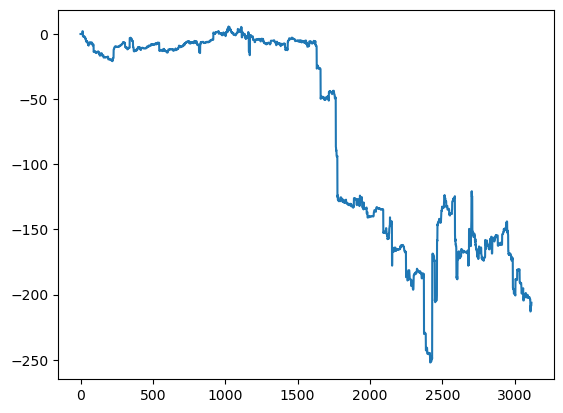

In [197]:
cumulative_returns = np.cumsum(returns)
plt.plot(cumulative_returns)
plt.show()

In [198]:
plt.savefig('/Users/hitengoel/Machine Learning/data analysis(technical indiactors)/data-analysis-with-technical-indicators/Pair Trading final/plots/without clustering/daily/SHSZ300 (CSI 300)_macd_rsi.png', dpi=300)

<Figure size 640x480 with 0 Axes>

In [199]:
def get_returns1(master_macd, master_rsi, prices):
    returns = []
    intrade = []
    i = 0
    while(i<len(prices)) :
        buy = 0
        buy_rsi = 100.0
        sell = 0
        sell_rsi = 0.0
        for j in range(1,len(prices.columns)):
            if(master_rsi.iloc[i,j]<30):
                if(master_rsi.iloc[i,j]<buy_rsi):
                    buy = j
                    buy_rsi = master_rsi.iloc[i,j]
            elif(master_rsi.iloc[i,j]>70):
                if(master_rsi.iloc[i,j]>sell_rsi):
                    sell = j
                    sell_rsi = master_rsi.iloc[i,j]

        if(len(intrade)==0) :
            returns.append(0)
            
        else :
            b1 = prices.iloc[intrade[0][0],intrade[0][1]]
            s1 = prices.iloc[intrade[0][0],intrade[0][3]]
            b2 = prices.iloc[i,intrade[0][1]]
            s2 = prices.iloc[i,intrade[0][3]]
            r = (((b2-b1))*intrade[0][2]) + ((s1-s2))
            returns.append(r)
            intrade.clear()

        
        if(buy!=0 and sell!=0) :
            buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
            l = [i,buy,buy_quantity,sell]
            intrade.append(l)
        
        i = i+1

    return returns, intrade

In [200]:
returns1,intrade1 = get_returns1(master_macd, master_rsi, prices)

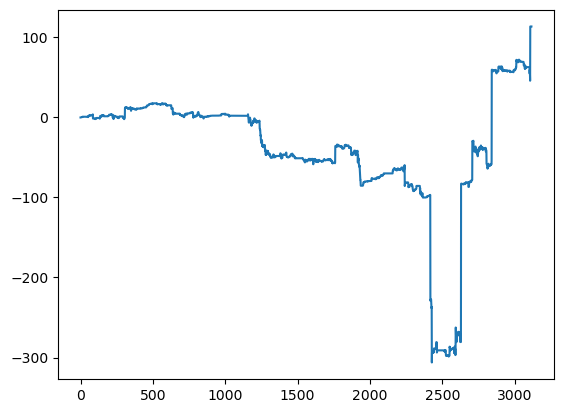

In [201]:
cumulative_returns = np.cumsum(returns1)
plt.plot(cumulative_returns)
plt.show()

In [202]:
plt.savefig('/Users/hitengoel/Machine Learning/data analysis(technical indiactors)/data-analysis-with-technical-indicators/Pair Trading final/plots/without clustering/daily/SHSZ300 (CSI 300)_rsi.png', dpi=300)

<Figure size 640x480 with 0 Axes>